In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import holidays
from typing import Union
from tqdm import tqdm

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import LeaveOneGroupOut
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Data Prep

In [25]:
## csv are stored locally in same directory as notebook for this assignment
## this makes things easy, but typically I'd expect that data comes from SQL-queries or a feature-store
weather_path = "data/weather_data.csv"
load_path = "data/load_hist_data.csv"
estimates_path = "data/probability_estimates.csv"

In [26]:
# 4 years of weather data in the file “weather_data.csv” 
# There are 28 stations with hourly weather for each 
# Each row has date, hour of the day (1-24), Station ID, temperature (Fahrenheit) 

df_weather = pd.read_csv(weather_path, parse_dates=['Date'])
print('\nInfo:\n', df_weather.info())
print('\nDescribe:\n', df_weather.describe())
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981792 entries, 0 to 981791
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         981792 non-null  datetime64[ns]
 1   Hour         981792 non-null  int64         
 2   Station ID   981792 non-null  int64         
 3   Temperature  981792 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.0 MB

Info:
 None

Describe:
                                 Date          Hour     Station ID  \
count                         981792  981792.00000  981792.000000   
mean   2007-01-01 00:36:47.802874880      12.50000      14.500000   
min              2005-01-01 00:00:00       1.00000       1.000000   
25%              2006-01-01 00:00:00       6.75000       7.750000   
50%              2007-01-01 00:00:00      12.50000      14.500000   
75%              2008-01-01 00:00:00      18.25000      21.250000   
max              2008-12

,Date,Hour,Station ID,Temperature
0,2005-01-01,1,1,43
1,2005-01-01,2,1,41
2,2005-01-01,3,1,40
3,2005-01-01,4,1,39
4,2005-01-01,5,1,38


In [27]:
## how many weather stations?
df_weather['Station ID'].nunique()

28

In [28]:
## will I have this data for the prediction year (2008)?
df_weather['Date'].min(), df_weather['Date'].max()
## yes, so I can use these features to help predict "Is Peak" target

(Timestamp('2005-01-01 00:00:00'), Timestamp('2008-12-31 00:00:00'))

In [29]:
## create a dataframe with all hours and dates to detecting and filling missing data
all_dates = pd.DataFrame(pd.date_range(start=df_weather['Date'].min(), end=df_weather['Date'].max(), freq='D'), columns=['Date'])
hours = pd.DataFrame([x for x in range(1,25)], columns=['Hour'])
all_date_hours = all_dates.merge(hours, how='cross')

In [30]:
### are there duplicate weather records?
weather_duplicated = df_weather[df_weather.duplicated(['Date', 'Hour', 'Station ID'], keep=False)].sort_values(['Date', 'Hour'])
print('Min Temp in duplicates: ', weather_duplicated['Temperature'].min())
print('Max Temp in duplicates: ', weather_duplicated['Temperature'].max())
## there are numerous duplicates, but the values seem reasonable... 
weather_duplicated

Min Temp in duplicates:  31
Max Temp in duplicates:  58


,Date,Hour,Station ID,Temperature
7248,2005-10-30,2,1,41
7249,2005-10-30,2,1,39
42312,2005-10-30,2,2,37
42313,2005-10-30,2,2,37
77376,2005-10-30,2,3,33
...,...,...,...,...
910225,2008-11-02,2,26,41
945288,2008-11-02,2,27,46
945289,2008-11-02,2,27,44
980352,2008-11-02,2,28,40


In [31]:

## since we don't have location-ID info for the load data, I will aggregate the weather data
## this will also deal with the duplicate records within a Date<>Hour<>StationID
df_weather_agg = df_weather.groupby(['Date', 'Hour']).agg({
    'Temperature': ['max', 'min', 'median', 'mean', 'std', lambda x: x.max() - x.min()]
})

# flatten multi index columns and rename
df_weather_agg.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in df_weather_agg.columns.ravel()]
temp_name = 'Temperature_'
df_weather_agg.rename(columns={
    f'{temp_name}max': 'Max Temp',
    f'{temp_name}min': 'Min Temp',
    f'{temp_name}median': 'Median Temp',
    f'{temp_name}mean': 'Mean Temp',
    f'{temp_name}std': 'Stdev Temp',
    f'{temp_name}<lambda_0>': 'Temp Range'
}, inplace=True)
weather_cols = df_weather_agg.columns
df_weather_agg.reset_index(inplace=True)

## are we missing any weather records?
df_weather_all = df_weather_agg.merge(all_date_hours, how='outer', on=['Date', 'Hour'])
print(df_weather_all.shape[0]/df_weather_agg.shape[0])

# ## for simplicity, let's interpolate these missing weather values
# ## interpolation is not always the best solution, 
# ## but seems like a quick and logical fix for the purposes of this assignment
# ## interpolation is unlikely to create any unusual weather values
# Set 'Date' and 'Hour' as the index for time-based interpolation
df_weather_all.set_index(['Date', 'Hour'], inplace=True)
# Interpolate missing values
for col in weather_cols:
    df_weather_all[col] = df_weather_all[col].interpolate()
df_weather_all.reset_index(inplace=True)

## engineer some simple time features
## using the weather data for this because it continues into 2008 (prediction year)
## if I do this on the load data, we'll be missing these features
df_weather_all['Month'] = df_weather_all['Date'].dt.month
df_weather_all['Month Name'] = df_weather_all['Date'].dt.month_name()
df_weather_all['Year'] = df_weather_all['Date'].dt.year
df_weather_all['DOY'] = df_weather_all['Date'].dt.day_of_year
df_weather_all['DOW'] = df_weather_all['Date'].dt.day_of_week
df_weather_all['Day'] = df_weather_all['Date'].dt.day_name()
df_weather_all['Is Weekend'] =  np.where(df_weather_all['Day'].isin(['Saturday', 'Sunday']), 1, 0)

df_weather_all.head()


1.0001140901312036


,Date,Hour,Max Temp,Min Temp,Median Temp,Mean Temp,Stdev Temp,Temp Range,Month,Month Name,Year,DOY,DOW,Day,Is Weekend
0,2005-01-01,1,53.0,39.0,46.5,46.107143,3.413907,14.0,1,January,2005,1,5,Saturday,1
1,2005-01-01,2,53.0,38.0,46.5,45.964286,3.305239,15.0,1,January,2005,1,5,Saturday,1
2,2005-01-01,3,52.0,37.0,45.0,44.964286,3.271449,15.0,1,January,2005,1,5,Saturday,1
3,2005-01-01,4,52.0,37.0,46.0,45.178571,3.367091,15.0,1,January,2005,1,5,Saturday,1
4,2005-01-01,5,51.0,37.0,45.0,44.714286,3.609218,14.0,1,January,2005,1,5,Saturday,1


In [32]:
df_weather_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         35064 non-null  datetime64[ns]
 1   Hour         35064 non-null  int64         
 2   Max Temp     35064 non-null  float64       
 3   Min Temp     35064 non-null  float64       
 4   Median Temp  35064 non-null  float64       
 5   Mean Temp    35064 non-null  float64       
 6   Stdev Temp   35064 non-null  float64       
 7   Temp Range   35064 non-null  float64       
 8   Month        35064 non-null  int32         
 9   Month Name   35064 non-null  object        
 10  Year         35064 non-null  int32         
 11  DOY          35064 non-null  int32         
 12  DOW          35064 non-null  int32         
 13  Day          35064 non-null  object        
 14  Is Weekend   35064 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int32(4), int64(2),

In [33]:
# 3 years of load history in the file “load_hist_data.csv” 
# Times are matching weather data 
# Each row has date, hour of the day (1-24), load for that hour

df_load = pd.read_csv(load_path, parse_dates=['Date'])
print('\nInfo:\n', df_load.info())
## no missing values (nulls)
print('\nDescribe:\n', df_load.describe())
## we can see that there are not crazy outliers from the "Describe" calculations
df_load.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26280 non-null  datetime64[ns]
 1   Hour    26280 non-null  int64         
 2   Load    26280 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 616.1 KB

Info:
 None

Describe:
                                 Date          Hour          Load
count                          26280  26280.000000  26280.000000
mean   2006-07-02 00:36:03.287671168     12.500000   1071.858866
min              2005-01-01 00:00:00      1.000000    509.000000
25%              2005-10-01 00:00:00      6.750000    854.000000
50%              2006-07-02 00:00:00     12.500000   1009.000000
75%              2007-04-02 00:00:00     18.250000   1252.000000
max              2007-12-31 00:00:00     24.000000   2266.000000
std                              NaN      6.922318    313.951126


,Date,Hour,Load
0,2005-01-01,1,857
1,2005-01-01,2,825
2,2005-01-01,3,800
3,2005-01-01,4,794
4,2005-01-01,5,802


In [34]:
## Do we have any missing values (date-hours) that are expected?
df_load.groupby(['Date'])['Load'].count().describe()

count    1095.000000
mean       24.000000
std         0.074057
min        23.000000
25%        24.000000
50%        24.000000
75%        24.000000
max        25.000000
Name: Load, dtype: float64

In [35]:
counts = df_load.groupby(['Date'])['Load'].count().reset_index()
counts[counts['Load']!=24]

,Date,Load
92,2005-04-03,23
302,2005-10-30,25
456,2006-04-02,23
666,2006-10-29,25
799,2007-03-11,23
1037,2007-11-04,25


In [36]:
missing_hours = df_load[df_load['Date'].isin(counts[counts['Load']<24]['Date'].unique())]
missing_hours['Date'].unique()

<DatetimeArray>
['2005-04-03 00:00:00', '2006-04-02 00:00:00', '2007-03-11 00:00:00']
Length: 3, dtype: datetime64[ns]

In [37]:
## 3 dates with missing hours, I can manually fix these because there are so few, or just do a bulk correction with interpolation
df_load_all = df_load.merge(all_date_hours, how='outer', on=['Date', 'Hour']).sort_values(['Date', 'Hour'])
## interpolate any missing Load values
# Set 'Date' and 'Hour' as the index for time-based interpolation
df_load_all.set_index(['Date', 'Hour'], inplace=True)
# Interpolate missing values
df_load_all['Load'] = df_load_all['Load'].interpolate()
# Reset the index if needed
df_load_all.reset_index(inplace=True)
df_load_all.groupby(['Date'])['Load'].count().describe()

count    1461.000000
mean       24.002053
std         0.045283
min        24.000000
25%        24.000000
50%        24.000000
75%        24.000000
max        25.000000
Name: Load, dtype: float64

In [38]:
counts_all = df_load_all.groupby(['Date'])['Load'].count().reset_index()
counts_all[counts_all['Load']!=24]

,Date,Load
302,2005-10-30,25
666,2006-10-29,25
1037,2007-11-04,25


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


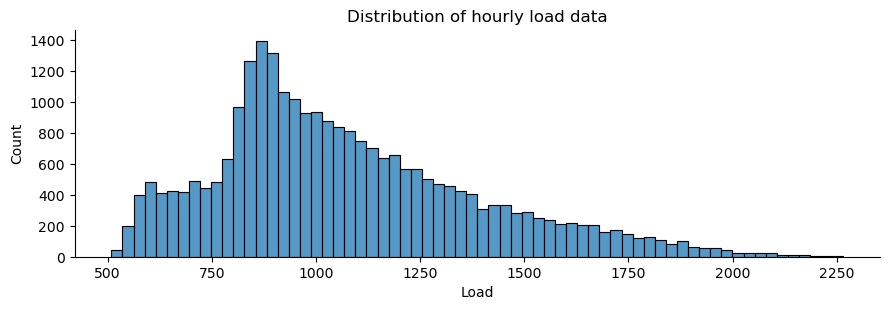

In [53]:
## do we have unusual target values?
## it seems fine from the .describe() above
## just check the distribution
sns.displot(df_load, x='Load', aspect=3, height=3)
plt.title('Distribution of hourly load data')
plt.show()

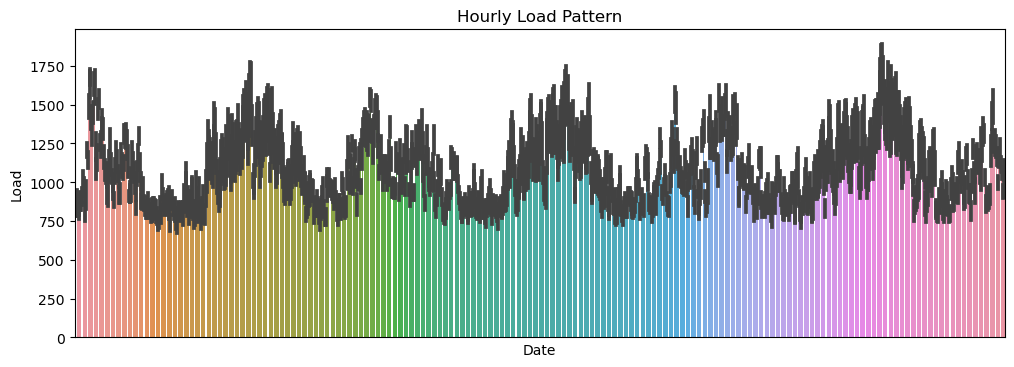

In [54]:
## plot the pattern over time to check for issues
plt.figure(figsize=(12,4))
sns.barplot(x='Date', y='Load', data=df_load)
plt.xlabel('Date')
plt.xticks([])
plt.title('Hourly Load Pattern')
plt.show();
## seems reasonable and highly patterned


In [55]:
## are there duplicates?
print('Fraction of duplicates: ', df_load.shape[0]/df_load.drop_duplicates(['Date', 'Hour']).shape[0])
## almost none...

## what are the duplicates?
dupes = df_load[df_load.duplicated(['Date', 'Hour'], keep=False)].sort_values(['Date', 'Hour'])
dupes


Fraction of duplicates:  1.0001141682840506


,Date,Hour,Load
7248,2005-10-30,2,888
7249,2005-10-30,2,888
15984,2006-10-29,2,802
15985,2006-10-29,2,802
24888,2007-11-04,2,768
24889,2007-11-04,2,768


In [56]:
## check duplicates
extra_hour = counts[counts['Load']==25]['Date']
df_load[df_load['Date'].isin(extra_hour)].head(30)

,Date,Hour,Load
7247,2005-10-30,1,895
7248,2005-10-30,2,888
7249,2005-10-30,2,888
7250,2005-10-30,3,917
7251,2005-10-30,4,950
7252,2005-10-30,5,995
7253,2005-10-30,6,1061
7254,2005-10-30,7,1150
7255,2005-10-30,8,1261
7256,2005-10-30,9,1240


In [57]:
### these are identical so we can drop them.
## this handles the duplicates
df_load_clean = df_load_all[~df_load_all.duplicated(['Date', 'Hour'])].copy()
print('Size reduction from de-duping: ', df_load_clean.shape[0]/df_load_all.shape[0])

df_load_clean.info()

Size reduction from de-duping:  0.9999144494824194
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 0 to 35066
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    35064 non-null  datetime64[ns]
 1   Hour    35064 non-null  int64         
 2   Load    35064 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.1 MB


In [58]:
## add holiday data and engineer features
## use the holidays library to get US public holidays for several years
## add extra years beginning and end to ensure that we have buffer data 
# ## for the feature engineering on the temporal edges of the data
us_holidays = holidays.UnitedStates(years=[2003, 2004, 2005, 2006, 2007, 2008, 2009])  
us_holidays = pd.DataFrame.from_dict(us_holidays.items())
us_holidays.columns = ['Date', 'Holiday']
us_holidays['Date'] = pd.to_datetime(us_holidays['Date'])
us_holidays.sort_values('Date', inplace=True)

## engineer features around holidays
us_holidays['Previous Holiday'] = us_holidays['Date'].shift(1)
us_holidays['Next Holiday'] = us_holidays['Date'].shift(-1)
## add the dates between holidays too for feature engineering
all_dates_extended = pd.DataFrame(pd.date_range(start=us_holidays['Date'].min(), end=us_holidays['Date'].max(), freq='D'), columns=['Date'])
df_holidays = us_holidays.merge(all_dates_extended, how='right', on=['Date'])
## fill the previous and next holidays
df_holidays['Previous Holiday'].bfill(inplace=True)
df_holidays['Next Holiday'].ffill(inplace=True)
## engineer features
df_holidays['Is Holiday'] = df_holidays['Holiday'].notnull().astype(int)
df_holidays['Days Since Holiday'] = (df_holidays['Date'] - df_holidays['Previous Holiday']).dt.days
df_holidays['Days Until Holiday'] = (df_holidays['Next Holiday'] - df_holidays['Date']).dt.days
## correct for holiday dates (set counter values to zero on Holiday dates)
df_holidays['Days Since Holiday'] = np.where(df_holidays['Holiday'].notna(), 0, df_holidays['Days Since Holiday'])
df_holidays['Days Until Holiday'] = np.where(df_holidays['Holiday'].notna(), 0, df_holidays['Days Until Holiday'])

# cleanup
# drop the older and newer data we don't need
df_holidays = df_holidays[(df_holidays['Date']>= pd.to_datetime('2004-01-01')) & (df_holidays['Date']< pd.to_datetime('2009-01-01'))].copy()
# drop columns
df_holidays.drop(columns=['Previous Holiday', 'Next Holiday'],inplace=True)
# fill missing holiday values
df_holidays['Holiday'].fillna('Non-Holiday', inplace=True)
# check that counters look good
df_holidays.head(25)

,Date,Holiday,Is Holiday,Days Since Holiday,Days Until Holiday
365,2004-01-01,New Year's Day,1,0,0
366,2004-01-02,Non-Holiday,0,1,17
367,2004-01-03,Non-Holiday,0,2,16
368,2004-01-04,Non-Holiday,0,3,15
369,2004-01-05,Non-Holiday,0,4,14
370,2004-01-06,Non-Holiday,0,5,13
371,2004-01-07,Non-Holiday,0,6,12
372,2004-01-08,Non-Holiday,0,7,11
373,2004-01-09,Non-Holiday,0,8,10
374,2004-01-10,Non-Holiday,0,9,9


In [59]:
## combine the data together
## we're blending hourly and daily data
df_comb = df_load_clean.merge(
    df_weather_all, 
    how='outer', 
    on=['Date', 'Hour']
).merge(
    df_holidays,
    how='outer',
    on=['Date']
)

## create the scoring dataframe
df_scoring = df_comb[df_comb['Date']>= pd.to_datetime('2008-01-01')].copy()
## drop records without load data
df = df_comb[(df_comb['Load'] > 0) & (df_comb['Date'] < pd.to_datetime('2008-01-01'))].copy()

## Create the target variable
## get the max load for each day, and take the first max-hour if there is a tie
## this tie-breaker is a bit slow
df['Is Peak'] = df.groupby('Date')['Load'].transform(lambda x: (x == x.max()) & (df['Hour'] == df.loc[x.idxmax(), 'Hour'])).astype(int)
df

,Date,Hour,Load,Max Temp,Min Temp,Median Temp,Mean Temp,Stdev Temp,Temp Range,Month,...,Year,DOY,DOW,Day,Is Weekend,Holiday,Is Holiday,Days Since Holiday,Days Until Holiday,Is Peak
0,2005-01-01,1.0,857.0,53.0,39.0,46.5,46.107143,3.413907,14.0,1.0,...,2005.0,1.0,5.0,Saturday,1.0,New Year's Day,1,0,0,0
1,2005-01-01,2.0,825.0,53.0,38.0,46.5,45.964286,3.305239,15.0,1.0,...,2005.0,1.0,5.0,Saturday,1.0,New Year's Day,1,0,0,0
2,2005-01-01,3.0,800.0,52.0,37.0,45.0,44.964286,3.271449,15.0,1.0,...,2005.0,1.0,5.0,Saturday,1.0,New Year's Day,1,0,0,0
3,2005-01-01,4.0,794.0,52.0,37.0,46.0,45.178571,3.367091,15.0,1.0,...,2005.0,1.0,5.0,Saturday,1.0,New Year's Day,1,0,0,0
4,2005-01-01,5.0,802.0,51.0,37.0,45.0,44.714286,3.609218,14.0,1.0,...,2005.0,1.0,5.0,Saturday,1.0,New Year's Day,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2007-12-31,20.0,1269.0,50.0,37.0,43.0,42.678571,3.197842,13.0,12.0,...,2007.0,365.0,0.0,Monday,0.0,Non-Holiday,0,6,1,0
26276,2007-12-31,21.0,1255.0,48.0,30.0,43.0,41.785714,4.289152,18.0,12.0,...,2007.0,365.0,0.0,Monday,0.0,Non-Holiday,0,6,1,0
26277,2007-12-31,22.0,1237.0,49.0,34.0,41.5,41.107143,4.039979,15.0,12.0,...,2007.0,365.0,0.0,Monday,0.0,Non-Holiday,0,6,1,0
26278,2007-12-31,23.0,1212.0,49.0,32.0,41.0,40.571429,4.031621,17.0,12.0,...,2007.0,365.0,0.0,Monday,0.0,Non-Holiday,0,6,1,0


In [60]:
## check for missing values in combined data
df.info()
## looks good

<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 0 to 26279
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                26280 non-null  datetime64[ns]
 1   Hour                26280 non-null  float64       
 2   Load                26280 non-null  float64       
 3   Max Temp            26280 non-null  float64       
 4   Min Temp            26280 non-null  float64       
 5   Median Temp         26280 non-null  float64       
 6   Mean Temp           26280 non-null  float64       
 7   Stdev Temp          26280 non-null  float64       
 8   Temp Range          26280 non-null  float64       
 9   Month               26280 non-null  float64       
 10  Month Name          26280 non-null  object        
 11  Year                26280 non-null  float64       
 12  DOY                 26280 non-null  float64       
 13  DOW                 26280 non-null  float64       


In [61]:
df['Date'].nunique(), df[df['Is Peak']==1]['Date'].nunique()

(1095, 1095)

In [62]:
## confirm each date has one and only one "Is Peak" = True value
df.groupby(['Date'])['Is Peak'].sum().describe()

count    1095.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Is Peak, dtype: float64

## Brief EDA

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0.5, 1.0, 'Peak-hour distribution across the day')

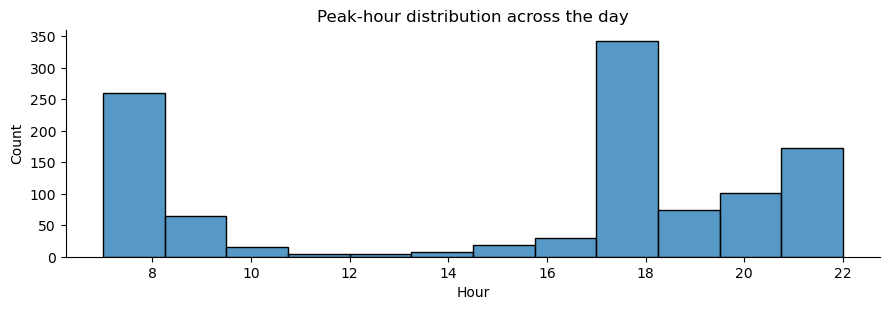

In [63]:
sns.displot(df[df['Is Peak']==1]['Hour'], aspect=3, height=3)
plt.title('Peak-hour distribution across the day')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


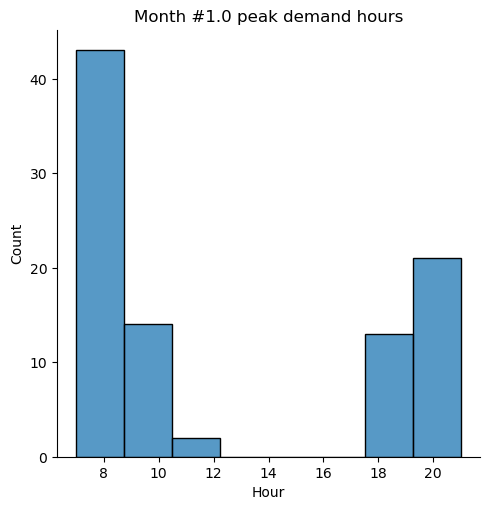

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


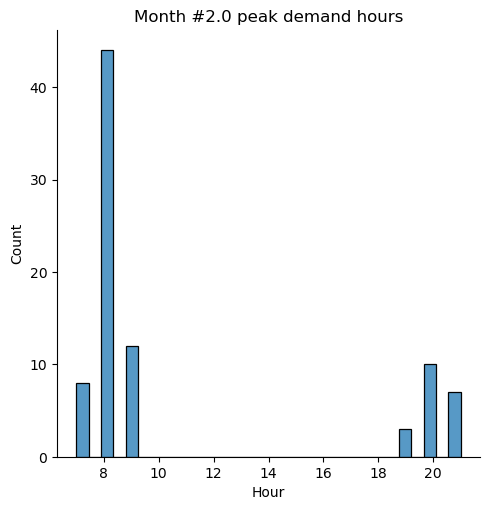

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


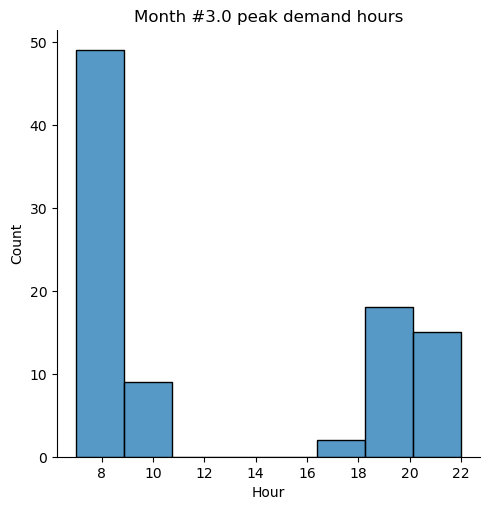

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


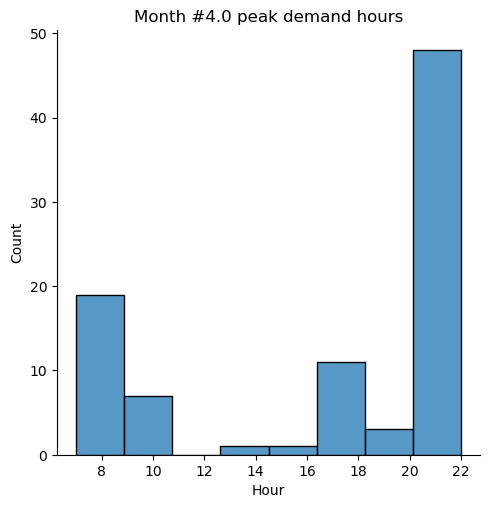

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


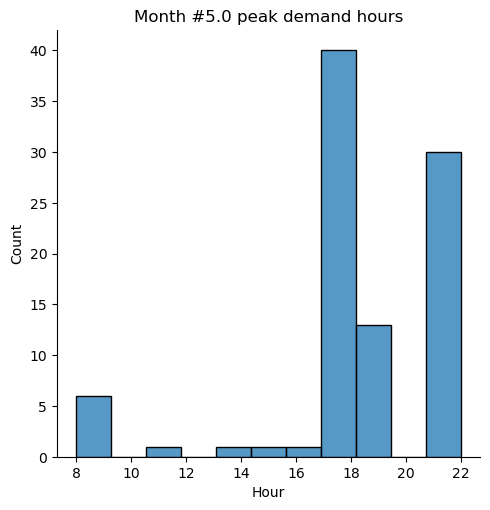

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


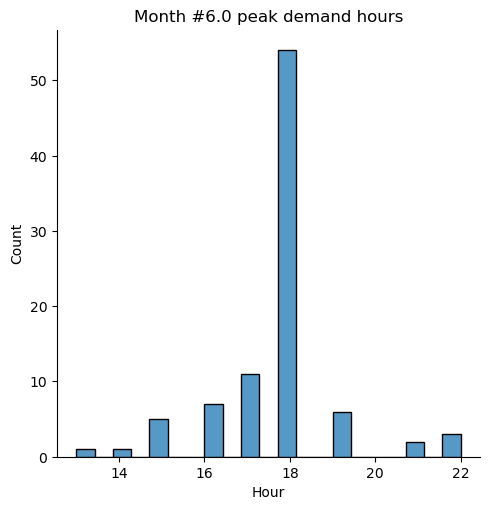

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


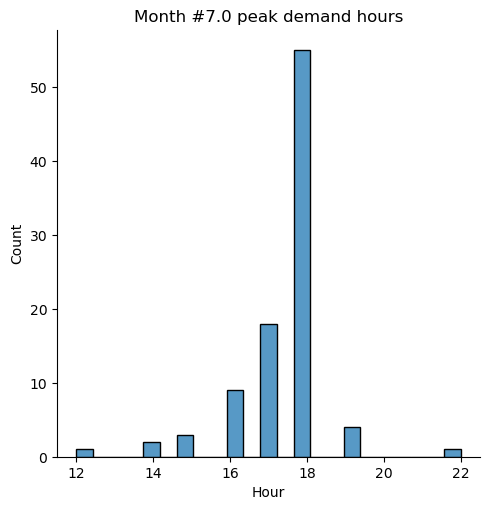

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


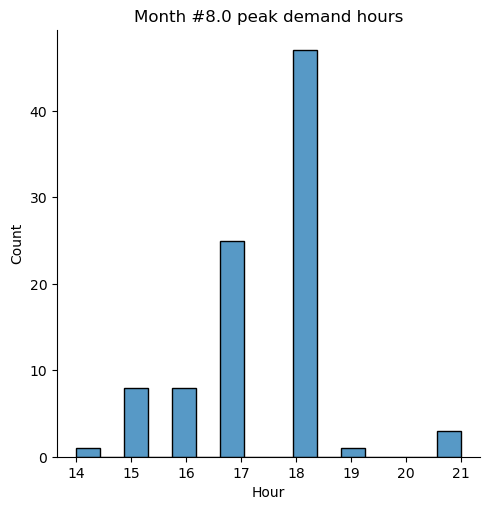

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


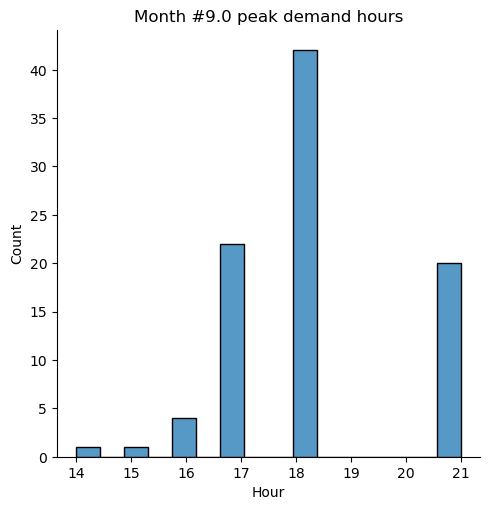

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


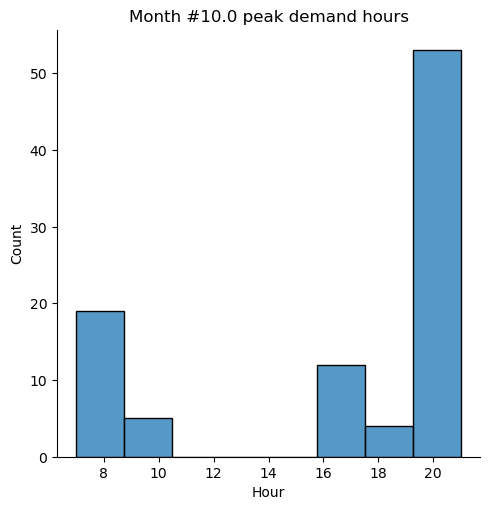

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


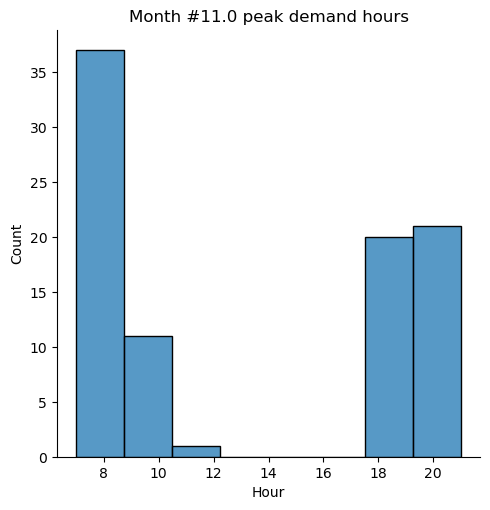

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


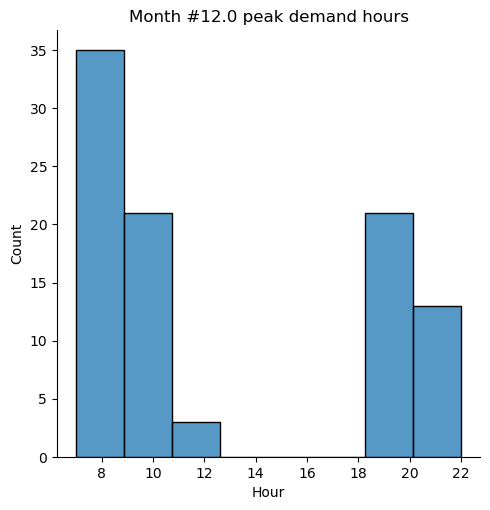

In [64]:
for m in df['Month'].unique():
    sns.displot(df[(df['Is Peak']==1) & (df['Month']==m)], x='Hour')
    plt.title(f'Month #{m} peak demand hours')
    plt.show();

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


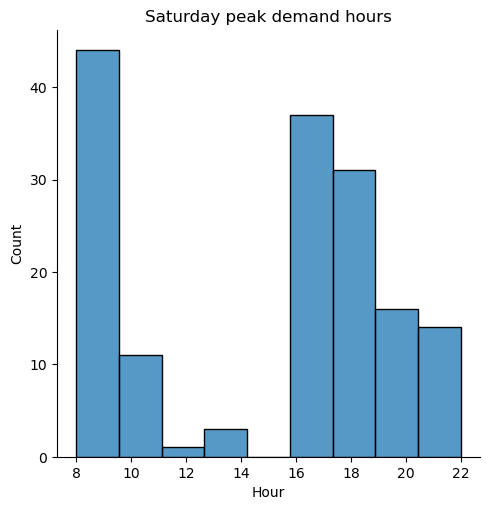

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


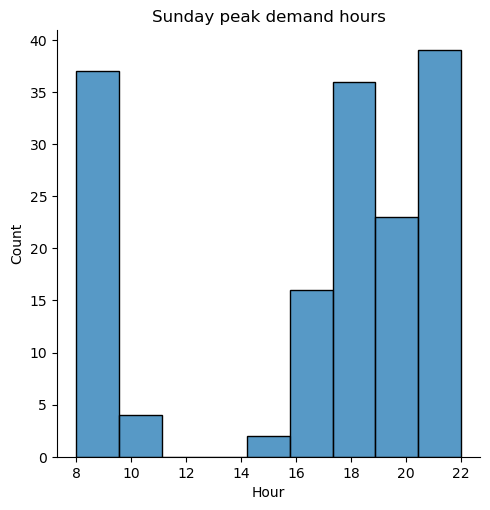

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


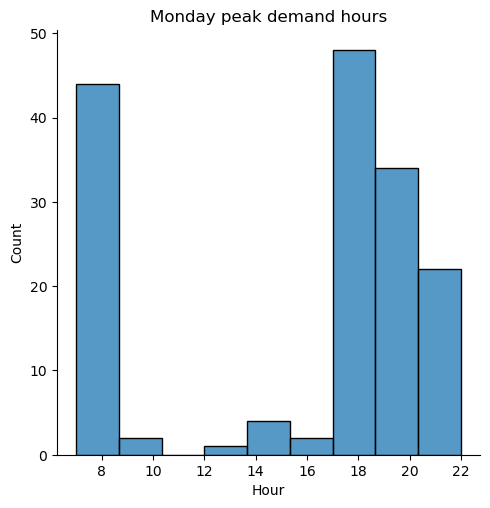

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


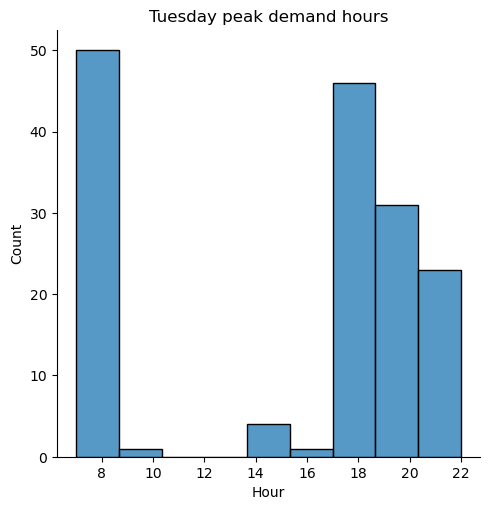

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


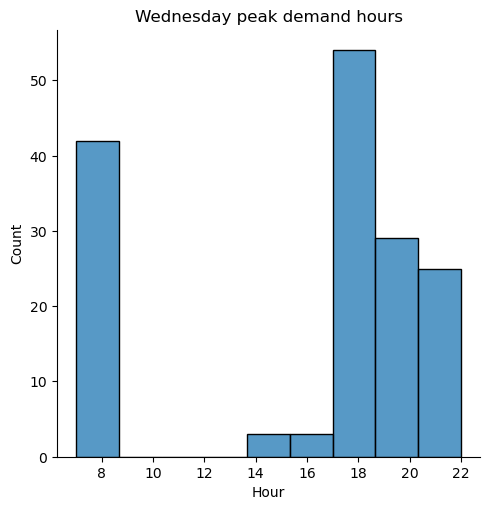

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


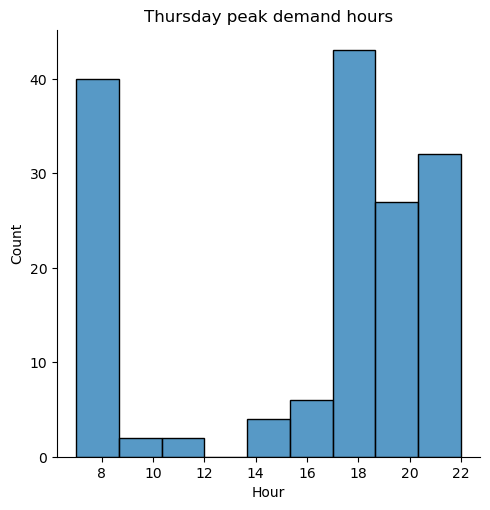

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


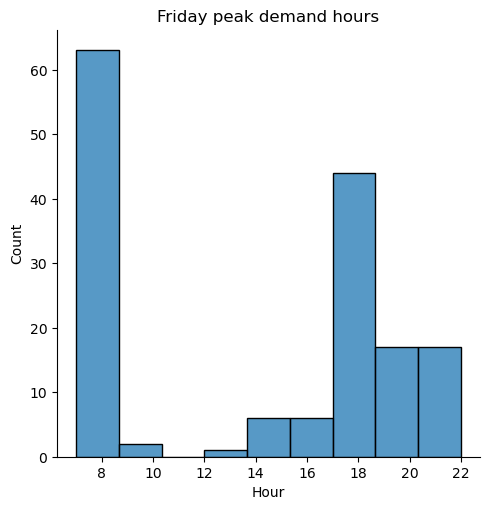

In [65]:
for d in df['Day'].unique():
    sns.displot(df[(df['Is Peak']==1) & (df['Day']==d)], x='Hour')
    plt.title(f'{d} peak demand hours')
    plt.show();

## Modeling

### Custom Metric

In [66]:
## the metric described in the assignment is squared-error, but the overall analysis of performance will be sum-square-error (SSE)
## instead of the more common mean-squared-error (MSE)
## this could be relevant if the SSE is used for downstream statistical analysis

def calculate_SE(p: float, a: float) -> float:
    """Custom metric to calculate error following the formula:
            S = (p-a)^2 where: 
        - p is the forecast probability 
        - a is the actual outcome (0 if not the peak hour, 1 if it’s the daily peak hour) 
        - S is the score for that hour
    """
    return (p-a)**2


def calculate_SSE_vectorized(p_vector: np.ndarray, a_vector: np.ndarray) -> np.ndarray:
    """
    Custom vectorized metric to calculate error for each row following the formula:
    S = (p - a)^2 where:
        - p_vector is the vector of forecast probabilities
        - a_vector is the vector of actual outcomes (0 if not the peak hour, 1 if it’s the daily peak hour)
        - Returns a vector of scores for each row
    """
    return np.sum(np.square(p_vector - a_vector))

print(calculate_SE(0.1, 0.2))
print(calculate_SSE_vectorized(np.array([0.1, 0.1, 0.1, 0.1]), np.array([0.2, 0.2, 0.2, 0.2])))

0.010000000000000002
0.04000000000000001


### Data Partitioning and Feature Engineering

The problem as described (predict "IsPeak" for each Date-Hour for a whole year), does not really fall into a typical forecasting problem given the data-granularity (hourly) and the forecast horizon (365 days * 24 hours = 8760 steps). Given that we'd have very long data-lag with using Load data, this seems to fall into a more classical binary-classification problem space but with temporal features.

Features used here include weather data, holiday data, and some temporal features (month, day of week, is weekend, etc.) and goal is for the model to learn temporal + weather information to determine Is-Peak hour. This data, however, could allow for the model to over-fit and memorize data if the data partitioning allows records within the same date to be spread across different partitions. Similarly, there could be some overall trend-data shifts that a random cross-validation approach could allow over-fitting.

A time-stratified approach is appropriate here. In a more classical forecasting problem situation, I'd use time-dependent backtest validation partitions with walk-forward validation using a fixed-window for training data. However, that doesn't seem like a great fit in this situation as we'd like to ensure that model is trained with sufficient data, and backtests would complicate this (i.e. using an expanding window makes comparison across validation partitions more complex as you're evaluating performance on different periods of time and with different amounts of training data).

Lacking more information, I'll use a simple year-based stratification approach and use 3-fold CV (2005, 2006, 2007) as we want to ensure that this model will generalize into 2008 data. This will essentially be a "leave-one-out" validation approach, but stratified on year.

In [67]:
df_load_clean['Date'].min(), df_load_clean['Date'].max()

(Timestamp('2005-01-01 00:00:00'), Timestamp('2008-12-31 00:00:00'))

## Modeling


In [68]:
## Naive Model
## It's always beneficial to have a very simple model to use as a baseline for comparison of more complex modeling approaches.
## For this use case, a baseline model can just be the average of the "Is Peak" target value for each Day-of-year record in the training data
## We can compare that to the validation data in the annual-stratified partitions and see a baseline performance

def naive_model(data: pd.DataFrame, target: str, group: Union[str, list[str]]) -> pd.DataFrame:
    """
    Naive model to predict probability based on average occurrence in training data.

    Args:
        data (pd.DataFrame): Historical data
        target (str): Name of Target column
        group (str): Name of group column
    
    Returns:
        predictions (pd.DataFrame): Probability predictions for each value in group
    """
    return data.groupby(group)[target].mean().reset_index()

naive_pred = naive_model(data=df[df['Year']!=2005], target='Is Peak', group= ['DOY', 'Hour'])
naive_pred

,DOY,Hour,Is Peak
0,1.0,1.0,0.0
1,1.0,2.0,0.0
2,1.0,3.0,0.0
3,1.0,4.0,0.0
4,1.0,5.0,0.0
...,...,...,...
8755,365.0,20.0,0.0
8756,365.0,21.0,0.0
8757,365.0,22.0,0.0
8758,365.0,23.0,0.0


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


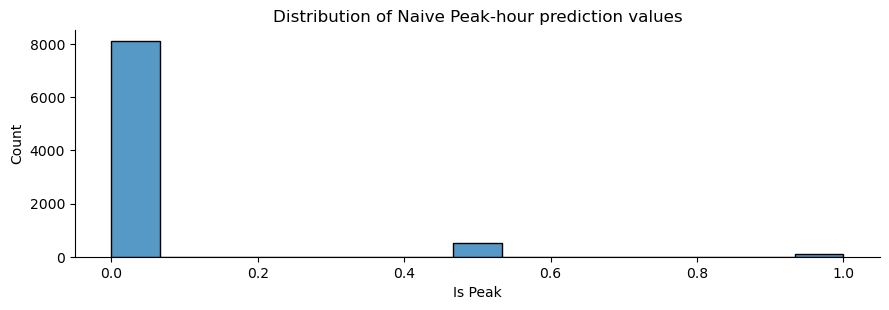

In [70]:
sns.displot(naive_pred['Is Peak'], aspect=3, height=3)
plt.title('Distribution of Naive Peak-hour prediction values')
plt.show();

In [71]:
## Modeling with CatBoost
## using CatBoost for this situation because of the ease of using Categorical features without additional encoding
## I won't worry about tuning the parameters here as that seems outside the scope of this assignment

## prepare data
X = df.drop(['Date', 'Load', 'Is Peak'], axis=1)
cat_features = ['Day', 'Month Name', 'Holiday']

y = df['Is Peak']
groups = df['Year']
multi_year_predictions = []
naive_multi_predictions = []
scores = []

## initialize the LeaveOneGroupOut cross-validator
logo = LeaveOneGroupOut()

## initialize CatBoost model
## different loss_functions can be used, and XGBoost or similar supports more custom loss functions
## catboost is convenient for categorical features, but less flexible
## use default parameters here
model = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, loss_function='Logloss') 

## cross-validation with year-partitions
for train_index, test_index in logo.split(X, y, groups=groups):
    ## split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    
    ## drop year info
    X_train.drop(columns=['Year'], inplace=True)
    X_test.drop(columns=['Year'], inplace=True)

    ## train model
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
    model.fit(train_pool, eval_set=eval_pool)

    ## make predictions on the test set
    predictions = model.predict_proba(X_test)[:,1]
    naive_predictions = naive_model(df_train, "Is Peak", ['DOY', 'Hour'])

    ## evaluate the model using the custom metric
    sse = calculate_SSE_vectorized(y_test, predictions)
    sse_naive = calculate_SSE_vectorized(y_test, naive_predictions['Is Peak'].values)
    print(f"SSE for CatBoost test fold: {sse}")
    print(f"SSE for Naive test fold: {sse_naive}")
    scores.append([sse, sse_naive])

    ## store the predictions
    tmp = pd.DataFrame(predictions, columns=['Prediction'])
    tmp['Year'] = df_test['Year'].unique()[0]
    multi_year_predictions.append(tmp)
    
## how does this compare to the naive model?
pd.DataFrame(scores, columns=['CatBoost', 'Naive'])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0:	learn: 0.6161276	test: 0.6168888	best: 0.6168888 (0)	total: 68.4ms	remaining: 6.77s
1:	learn: 0.5516948	test: 0.5527599	best: 0.5527599 (1)	total: 74.8ms	remaining: 3.66s
2:	learn: 0.4981969	test: 0.4994960	best: 0.4994960 (2)	total: 83.9ms	remaining: 2.71s
3:	learn: 0.4543449	test: 0.4558855	best: 0.4558855 (3)	total: 93.3ms	remaining: 2.24s
4:	learn: 0.4156299	test: 0.4173501	best: 0.4173501 (4)	total: 105ms	remaining: 1.99s
5:	learn: 0.3827176	test: 0.3843337	best: 0.3843337 (5)	total: 116ms	remaining: 1.81s
6:	learn: 0.3544217	test: 0.3560527	best: 0.3560527 (6)	total: 124ms	remaining: 1.65s
7:	learn: 0.3300918	test: 0.3317128	best: 0.3317128 (7)	total: 133ms	remaining: 1.52s
8:	learn: 0.3078506	test: 0.3095310	best: 0.3095310 (8)	total: 138ms	remaining: 1.4s
9:	learn: 0.2893436	test: 0.2913037	best: 0.2913037 (9)	total: 147ms	remaining: 1.32s
10:	learn: 0.2722185	test: 0.2740171	best: 0.2740171 (10)	total: 150ms	remaining: 1.21s
11:	learn: 0.2574367	test: 0.2594682	best: 0.2594


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1:	learn: 0.5517986	test: 0.5511065	best: 0.5511065 (1)	total: 13.1ms	remaining: 644ms
2:	learn: 0.4980710	test: 0.4972247	best: 0.4972247 (2)	total: 21ms	remaining: 680ms
3:	learn: 0.4542796	test: 0.4531022	best: 0.4531022 (3)	total: 28.8ms	remaining: 692ms
4:	learn: 0.4149655	test: 0.4136892	best: 0.4136892 (4)	total: 37.5ms	remaining: 712ms
5:	learn: 0.3821235	test: 0.3808367	best: 0.3808367 (5)	total: 45.7ms	remaining: 716ms
6:	learn: 0.3540452	test: 0.3530496	best: 0.3530496 (6)	total: 52.2ms	remaining: 693ms
7:	learn: 0.3298457	test: 0.3289286	best: 0.3289286 (7)	total: 59.1ms	remaining: 679ms
8:	learn: 0.3076532	test: 0.3066953	best: 0.3066953 (8)	total: 65.2ms	remaining: 659ms
9:	learn: 0.2892358	test: 0.2883793	best: 0.2883793 (9)	total: 72.4ms	remaining: 651ms
10:	learn: 0.2721353	test: 0.2714901	best: 0.2714901 (10)	total: 73.9ms	remaining: 598ms
11:	learn: 0.2573801	test: 0.2567718	best: 0.2567718 (11)	total: 82.2ms	remaining: 603ms
12:	learn: 0.2452618	test: 0.2448481	best


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8:	learn: 0.3040777	test: 0.3051055	best: 0.3051055 (8)	total: 47.4ms	remaining: 479ms
9:	learn: 0.2851079	test: 0.2860904	best: 0.2860904 (9)	total: 52.3ms	remaining: 470ms
10:	learn: 0.2686952	test: 0.2697860	best: 0.2697860 (10)	total: 59.1ms	remaining: 478ms
11:	learn: 0.2540205	test: 0.2549247	best: 0.2549247 (11)	total: 60.7ms	remaining: 445ms
12:	learn: 0.2412252	test: 0.2422473	best: 0.2422473 (12)	total: 67.6ms	remaining: 453ms
13:	learn: 0.2307814	test: 0.2318708	best: 0.2318708 (13)	total: 74.5ms	remaining: 457ms
14:	learn: 0.2203852	test: 0.2216599	best: 0.2216599 (14)	total: 81.4ms	remaining: 461ms
15:	learn: 0.2096680	test: 0.2109335	best: 0.2109335 (15)	total: 88.7ms	remaining: 465ms
16:	learn: 0.2002811	test: 0.2017346	best: 0.2017346 (16)	total: 95.6ms	remaining: 467ms
17:	learn: 0.1937633	test: 0.1954765	best: 0.1954765 (17)	total: 103ms	remaining: 468ms
18:	learn: 0.1863850	test: 0.1881282	best: 0.1881282 (18)	total: 109ms	remaining: 465ms
19:	learn: 0.1791995	test: 

,CatBoost,Naive
0,248.144713,394.5
1,241.722646,382.5
2,246.526532,415.5


In [72]:
# Task: Compute the probability of each hour of the following year (2008) being the peak load hour of the day. 
# A file named “probability_estimates.csv” is provided with each row having a Date, Hour and an empty 
# column for the daily peak probability, which you will have to fill in.  
# For simplicity no day has two peak hours. 
# Please note that hours here are (1-24) and not (0-23)

## Now train the model on all of the data and make predictions for 2008
# prepare scoring data
X_scoring = df_scoring.drop(['Date', 'Load'], axis=1)

# train model
final_model = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, loss_function='Logloss')
final_model.fit(Pool(X, label=y, cat_features=cat_features))

# final predictions
predictions_2008 = final_model.predict_proba(X_scoring)[:,1]
## add convenient features
predictions_output = df_scoring[['Date', 'Hour']].copy()
predictions_output['Daily Peak Probability'] = predictions_2008
predictions_output.to_csv('predictions/Bultema_2008_predictions_file.csv', index=None)
predictions_output

0:	learn: 0.6146429	total: 9.01ms	remaining: 892ms
1:	learn: 0.5507536	total: 18.7ms	remaining: 915ms
2:	learn: 0.4968969	total: 26.5ms	remaining: 858ms
3:	learn: 0.4508711	total: 28.7ms	remaining: 690ms
4:	learn: 0.4126447	total: 36.9ms	remaining: 702ms
5:	learn: 0.3800747	total: 44.8ms	remaining: 703ms
6:	learn: 0.3505969	total: 54ms	remaining: 718ms
7:	learn: 0.3265801	total: 62.1ms	remaining: 714ms
8:	learn: 0.3051818	total: 70.2ms	remaining: 710ms
9:	learn: 0.2866449	total: 73.2ms	remaining: 659ms
10:	learn: 0.2686270	total: 81.5ms	remaining: 660ms
11:	learn: 0.2519563	total: 89.4ms	remaining: 655ms
12:	learn: 0.2373503	total: 96.8ms	remaining: 648ms
13:	learn: 0.2266728	total: 102ms	remaining: 625ms
14:	learn: 0.2161873	total: 109ms	remaining: 620ms
15:	learn: 0.2062496	total: 118ms	remaining: 620ms
16:	learn: 0.1983998	total: 126ms	remaining: 616ms
17:	learn: 0.1896889	total: 135ms	remaining: 614ms
18:	learn: 0.1825719	total: 143ms	remaining: 609ms
19:	learn: 0.1755304	total: 15

,Date,Hour,Daily Peak Probability
26280,2008-01-01,1.0,0.006240
26281,2008-01-01,2.0,0.006057
26282,2008-01-01,3.0,0.005542
26283,2008-01-01,4.0,0.006591
26284,2008-01-01,5.0,0.006858
...,...,...,...
35059,2008-12-31,20.0,0.219502
35060,2008-12-31,21.0,0.232679
35061,2008-12-31,22.0,0.022275
35062,2008-12-31,23.0,0.008804


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


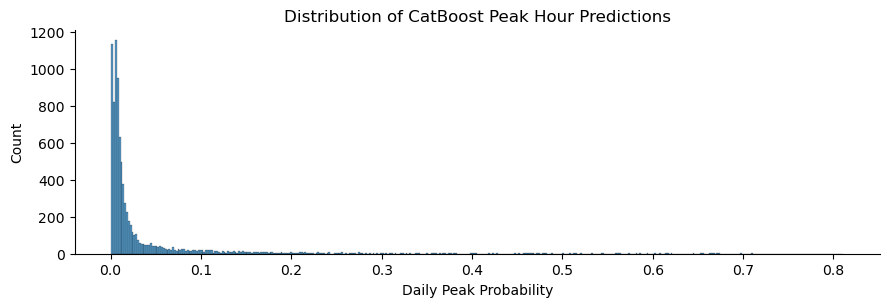

In [73]:
sns.displot(predictions_output['Daily Peak Probability'], aspect=3, height=3)
plt.title('Distribution of CatBoost Peak Hour Predictions')
plt.show();

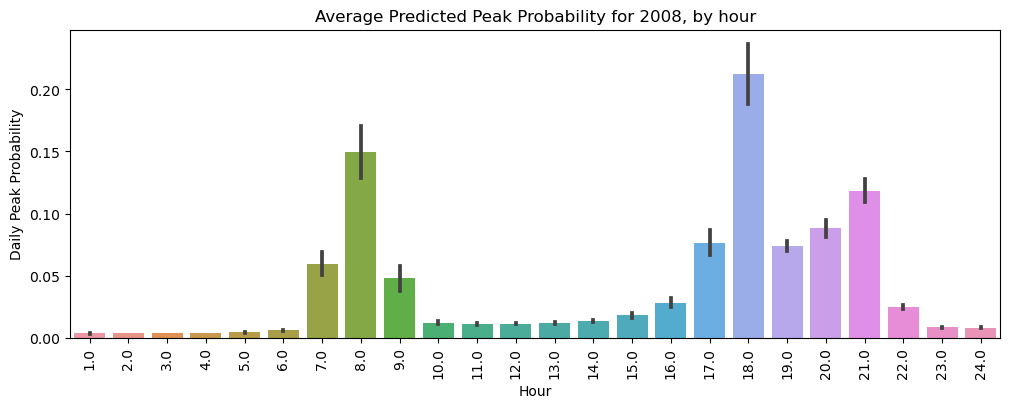

In [74]:
plt.figure(figsize=(12,4))
sns.barplot(x='Hour', y='Daily Peak Probability', data= predictions_output)
plt.xticks(rotation=90)
plt.title('Average Predicted Peak Probability for 2008, by hour')
plt.show();

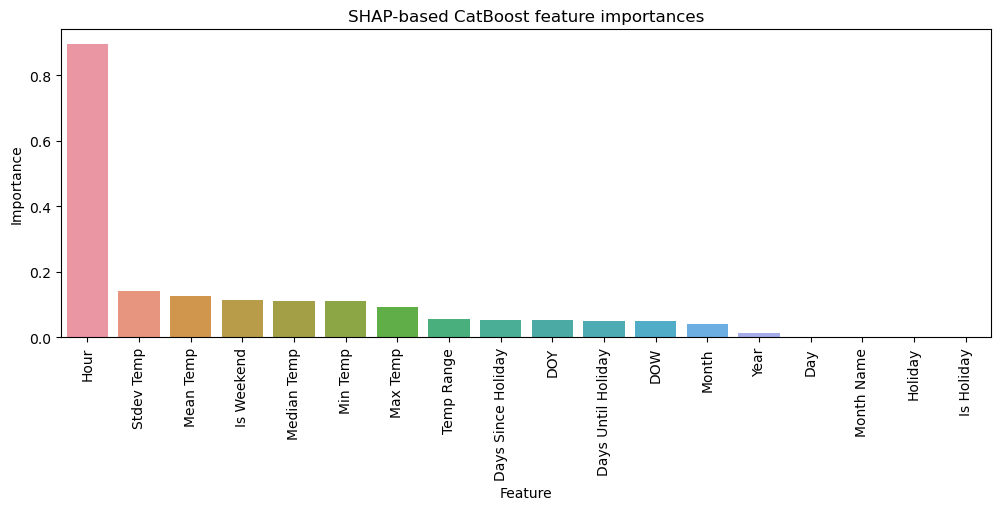

In [75]:
## Brief model insights
feature_names = X_scoring.columns

# Explain the model predictions using SHAP values
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_scoring)

# Calculate the feature importances from SHAP values
feature_importances = pd.DataFrame(
    list(zip(feature_names, np.abs(shap_values).mean(axis=0))),
    columns=['Feature', 'Importance']
)

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importances
plt.figure(figsize=(12,4))
sns.barplot(x='Feature', y='Importance', data=feature_importances)
plt.xticks(rotation=90)
plt.title('SHAP-based CatBoost feature importances')
plt.show();